# Raster plotting of river profiles along the San Andreas fault
This notebook makes a plot of the raster hillshade, the channels coloured by their gradient, and the basins for a single tile along the San Andreas fault. You must specify the base directory for each tile.

Raster I/O is done using rasterio and plotting is done using cartopy. I use geopandas to read in the channel data.

In [44]:
import cartopy as cp
import cartopy.crs as ccrs
import rasterio as rio
import rasterio.mask
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
import numpy as np
import pandas as pd
import geopandas as gpd

First, specify the name of the tile and the base directory

In [58]:
tile_no = 'tile_58'
base_dir = '/home/bjdd72/san_andreas/'+tile_no+'/'

Now we'll use rasterio to read in the DEM and check the coordinate system

In [59]:
DEM = rio.open(base_dir+tile_no+'_HS.tif')
print(DEM.crs)
DEM.nodata

EPSG:32610


0.0

We can read the raster to an array and get the extent for cartopy plotting

In [60]:
bounds = DEM.bounds
# The data format is left, right, bottom, top (WARNING: this is a different order to the bounds in rasterio)
Extent = [bounds.left,bounds.right,bounds.bottom,bounds.top]
array = DEM.read(1)
array = array.astype('float')
array[array==0]=np.nan

## Read in the channel data

We will now read the river channel csv. This contains information about each 3rd order river in the tile. We'll use geopandas to read in the data

In [61]:
df = pd.read_csv(base_dir+tile_no+'_profiles_SO3.csv')
gdf = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.longitude, df.latitude))
gdf = gdf.set_crs(epsg=4326)
# convert to UTM 10 N (same as raster)
gdf2 = gdf.to_crs("EPSG:32610")
# remove NaNs
gdf2 = gdf2[gdf2['slope'] < 9999]

## Read in the basins

Read in the 3rd order basins shapefile to a pandas geodataframe


In [62]:
basins_gdf = gpd.read_file(base_dir+tile_no+'_basins.shp')
# convert the polygon geometry to UTM
basins_utm = basins_gdf.to_crs("EPSG:32610")
print(basins_utm)

     basin_id  basin_area     azimuth  deflection   latitude   longitude  \
0       30989         1.0  154.028077   19.838756  37.268788 -122.093629   
1       30989     79733.0  151.454647   16.949732  37.268788 -122.093629   
2       31004     10741.0   82.018083   45.369648  37.272989 -122.093680   
3       31172      9344.0  328.867701   14.102613  37.269185 -122.090150   
4       31221     40164.0  311.882232    3.263494  37.269185 -122.090128   
..        ...         ...         ...         ...        ...         ...   
479     49095     12634.0  112.482837   20.281740  37.163515 -121.989795   
480     49173     46409.0   97.039897   32.989383  37.162083 -121.991019   
481     49234     43363.0  343.278456   31.031210  37.161554 -121.990350   
482     49322     37172.0  279.406212   31.077198  37.158725 -121.989386   
483     49365     28369.0  333.395304   19.525848  37.158716 -121.989397   

     fault_dist  direction                                           geometry  
0    35

## Plotting
We'll now put all these together and plot the hillshade and the 3rd order basins. We'll overlay this with the rivers and colour the points by the channel slope.

<GeoAxesSubplot:>

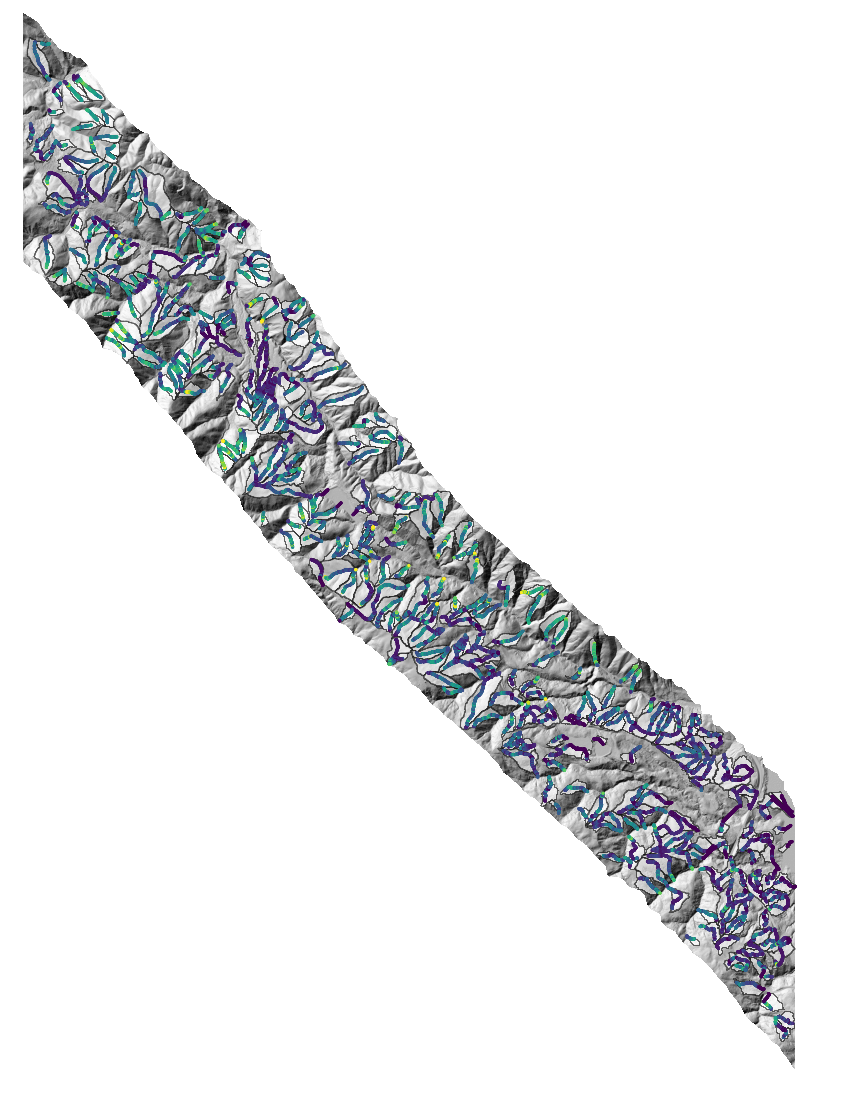

In [63]:
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.UTM(10))
# Limit the extent of the map to a small longitude/latitude range.
ax.set_extent(Extent, crs=ccrs.UTM(10))
#ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
#print('Projecting and plotting image (this may take a while)...')
ax.imshow(array, extent=Extent, transform=ccrs.UTM(10), origin="upper", cmap='gray', alpha=1, zorder=2)
ax.axis('off')

# now plot the channel data. We need to normalise the colours on a 0 to 1 scale
norm = colors.Normalize(vmin=0, vmax=1)
gdf2.plot(ax=ax, column='slope', markersize=4, zorder=10, cmap="viridis", norm=norm)

# now plot the basins 
basins_utm.plot(ax=ax, facecolor='white', edgecolor='k', alpha=0.6, zorder=5)

In [64]:
# save the figure
fig.savefig(base_dir+tile_no+'_raster_plot.png', dpi=300)

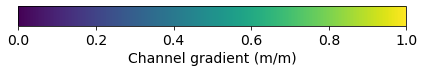

In [25]:
# Make a new figure to save the colourbar separately
fig,ax2 = plt.subplots()

# create the colourbar
cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap='viridis'), ax=ax2, orientation='horizontal')
cbar.ax.tick_params(labelsize=14)
cbar.set_label('Channel gradient (m/m)', fontsize=14)
ax2.remove()
plt.tight_layout()
fig.savefig(base_dir+tile_no+'_raster_plot_cbar.png', dpi=300)